# Natural Language Processing for the Fake News Challenge

## Main Imports

In [ ]:
import torch
import string
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional

!pip install transformers
import transformers

Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 2.3MB 8.4MB/s 
     |████████████████████████████████| 3.3MB 39.4MB/s 
     |████████████████████████████████| 901kB 44.2MB/s 


## Set up the data for preprocessing
### Load the data

In [80]:
main_path = '/content/drive/My Drive/University Work/Year 4/Natural Language Processing/'
data_folder_name = 'data'

train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'
test_body_filename = 'competition_test_bodies.csv'
test_stance_filename = 'competition_test_stances.csv'

train_body_path = main_path + data_folder_name +'/'+ train_body_filename 
train_stance_path = main_path + data_folder_name + '/' + train_stance_filename
test_body_path = main_path + data_folder_name + '/' + test_body_filename
test_stance_path = main_path + data_folder_name + '/' + test_stance_filename

train_body_data = pd.read_csv(train_body_path)
train_stance_data = pd.read_csv(train_stance_path)
test_body_data = pd.read_csv(test_body_path)
test_stance_data = pd.read_csv(test_stance_path)

### Preprocessing by removing stopwords and punctuation and applying stemming

In [73]:
def preprocess(text):

    text = nltk.tokenize.word_tokenize(text)
    text = [word for word in text if word not in nltk.corpus.stopwords.words('english')]
    text = (" ").join(text)

    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)

    ps = nltk.stem.PorterStemmer()
    text = nltk.tokenize.word_tokenize(text)

    text = [ps.stem(word) for word in text]
    text = (" ").join(text)

    return text

In [172]:
train_body_data['articleBody'] = train_body_data['articleBody'].apply(lambda x: preprocess(x))
train_stance_data['Headline'] = train_stance_data['Headline'].apply(lambda x: preprocess(x))
test_body_data['articleBody'] = test_body_data['articleBody'].apply(lambda x: preprocess(x))
test_stance_data['Headline'] = test_stance_data['Headline'].apply(lambda x: preprocess(x))

### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies with a Relevance column

In [194]:
train_total_data = pd.merge(train_body_data, train_stance_data, on='Body ID')
train_total_data['Relevance'] = np.where(train_total_data['Stance'] == 'unrelated', 0, 1)

test_total_data = pd.merge(test_body_data, test_stance_data, on='Body ID')
test_total_data['Relevance'] = np.where(test_total_data['Stance'] == 'unrelated', 0, 1)

train_total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
17083,1011,warn graphic imag A mask milit claim murder re...,journalist jame wright foley reportedli behead...,discuss,1
12504,740,A pictur began make round internet weekend cau...,‘ banksi ’ instagram tribut charli hebdo victi...,unrelated,0
19369,1155,A man head slap peopl carlisl sneez cumbria po...,A bunch Of folk pass around thi hoax video Of ...,unrelated,0
340,11,We ’ seen tradit depict god clouddwel figur fl...,islam state behead miss american journalist ja...,unrelated,0
3654,213,last year vine presid obama ’ trip israel show...,someon troll twitter think macklemor join isi,unrelated,0
8673,530,A homeless man given hundr dollar make cri you...,confu swirl detail murki arrest isi leader wife,unrelated,0
26148,1474,islam state IS milit stuf live scorpion canist...,islam state use scorpion bomb terrori victim,agree,1
42778,2230,By benjamin kang lim toni munro beijingseoul o...,parent anger seven bosnian schoolgirl age 13 1...,unrelated,0
1642,81,In week edit lie fake prank cheat internet bri...,‘ photo slain IS leader ’ report doctor,unrelated,0
13240,789,michael zehafbibeau slain gunman wednesday ’ s...,ottawa gunman identifi As michael zehafbibeau,agree,1


### Splitting the dataset into train and validation sets

In [242]:
train_input_columns = train_total_data[['Headline', 'articleBody']]
test_input_columns = test_total_data[['Headline', 'articleBody']]
target = 'Relevance'
#X_train, X_val, y_train, y_val = train_test_split(train_input_columns, train_total_data[target].values, test_size=0.20, random_state=0)

train_total_data = train_total_data.sample(frac=1)
X_train = train_total_data[['Headline', 'articleBody']]
y_train = train_total_data[['Relevance']].to_numpy()

X_test = test_total_data[['Headline', 'articleBody']]
y_test = test_total_data[['Relevance']].to_numpy()

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)
print('Size of testing set:', X_test.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)
Size of testing set: (25413, 2)


,Headline,articleBody
35983,heartwarm video show son reveal ’ paid parent ...,At least anytim soon internet saliv prospect g...
3478,islam state relea video appar show behead miss...,new york cnn war report jame foley nt write gl...
49162,7 teen girl get pregnant school trip read http...,seven girl age 13 14 fallen pregnant go school...
30322,kim jongun obe leader fractur ankl,islam state fighter match ebola world health o...
19868,small meteorit strike nicaragua capit citi man...,support islam state iraq syria milit group rec...
29845,boko haram deni truce relea kidnap schoolgirl,nicaragua govern said mysteri boom heard capit...
28321,forti year ago lego wrote power letter parent ...,A lego pamphlet 1974 unearth post reddit weeke...
37065,investig media report isi fighter contract ebola,world health organi investig report isi milit ...
35849,prankster give homeless man 100 secretli follo...,updat dec 31 2014 1130 est thi video prove per...
36062,cnn play alleg audiotap michael brown shooting...,new audio surfac allegedli captur moment micha...


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [199]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [239]:
min_df = 4
max_df = 0.5
max_features = 500

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=min_df, max_df=max_df, max_features=max_features, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=min_df, max_df=max_df, max_features=max_features, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
tfidf_train = preprocessor.fit_transform(X_train).todense()
#tfidf_val = preprocessor.transform(X_val).todense()
tfidf_test = preprocessor.transform(X_test).todense()
print('Train size: ', tfidf_train.shape)
#print('Val size: ', tfidf_val.shape)
print('Test size:', tfidf_test.shape)

Train size:  (49972, 1000)
Test size: (25413, 1000)


## Evaluation Metrics

### Confusion Matrix

In [ ]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [ ]:
# ROC Curve
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Display Classification Accuracies over results and plot Confusion Matrix and ROC Curve results

In [ ]:
def display_results(y_pred, y_val):

    # print classification report and plot confusion matrix and ROC curve
    print(classification_report(y_val, y_pred))
    plot_confusion_matrix(y_val, y_pred)
    plot_roc_curve(y_val, y_pred)

## Machine Learning Models

### Train Random Forest (RF) Classifier using TF-IDF Features and display results

In [240]:
tfidf_RF_model = RandomForestClassifier(random_state=0).fit(tfidf_train, y_train.ravel())
tfidf_RF_model.score(tfidf_test, y_test)

0.7369456577342305

              precision    recall  f1-score   support

           0       0.77      0.91      0.83     18349
           1       0.55      0.29      0.38      7064

    accuracy                           0.74     25413
   macro avg       0.66      0.60      0.60     25413
weighted avg       0.71      0.74      0.71     25413



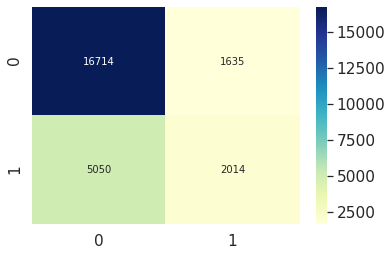

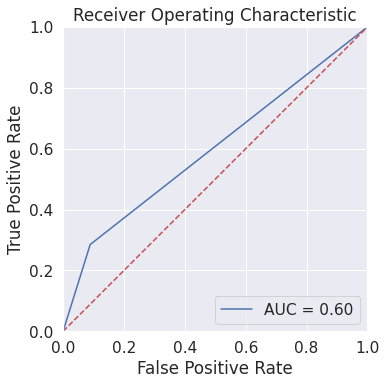

In [241]:
y_pred = tfidf_RF_model.predict(tfidf_test)
display_results(y_pred, y_test)

## Tokenisation with BERT

### Load the model and tokeniser

In [ ]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Embedding Retrieval

In [ ]:
def get_bert_embeddings(bert_model, data, batch_size):

    # set device and lambda function for classification token retrieval
    device = torch.device("cuda")
    get_cls_token_embeddings = lambda x: x[0][:, 0, :].squeeze()
    bert_embeddings = []  # initialise embeddings

    for i in range(batch_size, data.shape[0] + batch_size, batch_size):
    
        if i % 100 == 0:
            print("Batch", i)

        # tokenise
        tokenized = tokenizer(list(data['Headline'][i - batch_size:i]), list(data['articleBody'][i - batch_size:i]),\
                          padding='max_length', truncation=True, return_tensors="pt")
        
        # get input ids and set to device
        tokenized_text = tokenized['input_ids']
        tokenized_text = tokenized_text.to(device)

        # calculate embeddings and retrieve cls token embedding
        with torch.no_grad():
            word_embeddings = bert_model(tokenized_text)
        cls_token_embeddings = get_cls_token_embeddings(word_embeddings)

        # append to total embeddings
        if bert_embeddings == []:
            bert_embeddings = cls_token_embeddings
        else:
            bert_embeddings = torch.cat((bert_embeddings, cls_token_embeddings), 0)

        # clear cache and GPU memory
        del word_embeddings
        torch.cuda.empty_cache()

    return bert_embeddings

In [ ]:
device = torch.device("cuda")
bert_model = bert_model.to(device)
batch_size = 256

print("Training Set")
bert_train = get_bert_embeddings(bert_model, X_train, batch_size)
#torch.save(bert_train, main_path + 'bert_train.pt')

print("Testing Set")
bert_val = get_bert_embeddings(bert_model, X_val, batch_size)
#torch.save(bert_val, main_path + 'bert_val.pt')

Training Set
Batch 6400
Batch 12800
Batch 19200
Batch 25600
Batch 32000
Batch 38400
Testing Set
Batch 6400


In [ ]:
# load, detach from GPU, and convert to numpy arrays
bert_train = torch.load(main_path + 'bert_train.pt').detach().cpu().numpy()
bert_val = torch.load(main_path + 'bert_val.pt').detach().cpu().numpy()

### Train Random Forest (RF) Classifier using BERT Embeddings and display results

In [ ]:
bert_RF_model = RandomForestClassifier(random_state=0).fit(bert_train, y_train)
bert_RF_model.score(bert_val, y_val)

0.8963481740870435

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      7228
           1       0.93      0.68      0.78      2767

    accuracy                           0.90      9995
   macro avg       0.91      0.83      0.86      9995
weighted avg       0.90      0.90      0.89      9995



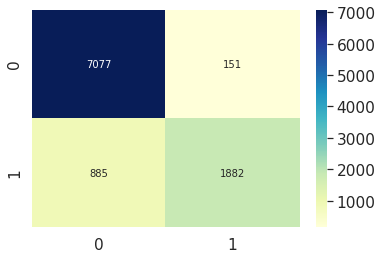

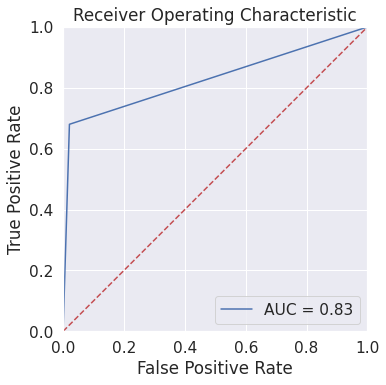

In [ ]:
y_pred = bert_RF_model.predict(bert_val)
display_results(y_pred, y_val)

## Deep Learning Models

### Train a Multi-Layer Perceptron (MLP) on TF-IDF Embeddings

#### Define the MLP

In [ ]:
tfidf_MLP = Sequential()
tfidf_MLP.add(Dense(64, activation='relu', input_dim=400))
tfidf_MLP.add(Dense(64, activation='relu'))
tfidf_MLP.add(Dense(1, activation='sigmoid'))
tfidf_MLP.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
print(tfidf_MLP.summary())

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 64)                25664     
_________________________________________________________________
dense_59 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 65        
Total params: 29,889
Trainable params: 29,889
Non-trainable params: 0
_________________________________________________________________
None


#### Train the MLP

In [ ]:
batch_size = 32
tfidf_MLP.fit(tfidf_train, y_train, batch_size=batch_size,
        epochs=10, validation_data=(tfidf_val, y_val),
        steps_per_epoch=tfidf_train.shape[0]/batch_size)

Epoch 1/10
1249/1249 [==============================] - 4s 3ms/step - loss: 0.4510 - accuracy: 0.7981 - val_loss: 0.1283 - val_accuracy: 0.9522
Epoch 2/10
1249/1249 [==============================] - 4s 3ms/step - loss: 0.0940 - accuracy: 0.9675 - val_loss: 0.0897 - val_accuracy: 0.9670
Epoch 3/10
1249/1249 [==============================] - 4s 3ms/step - loss: 0.0514 - accuracy: 0.9834 - val_loss: 0.0760 - val_accuracy: 0.9719
Epoch 4/10
1249/1249 [==============================] - 4s 3ms/step - loss: 0.0332 - accuracy: 0.9888 - val_loss: 0.0758 - val_accuracy: 0.9738
Epoch 5/10
1249/1249 [==============================] - 4s 3ms/step - loss: 0.0245 - accuracy: 0.9912 - val_loss: 0.0735 - val_accuracy: 0.9759
Epoch 6/10
1249/1249 [==============================] - 4s 3ms/step - loss: 0.0214 - accuracy: 0.9933 - val_loss: 0.0722 - val_accuracy: 0.9771
Epoch 7/10
1249/1249 [==============================] - 4s 3ms/step - loss: 0.0165 - accuracy: 0.9950 - val_loss: 0.0773 - val_accuracy:

### Display Results of MLP on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7228
           1       0.96      0.96      0.96      2767

    accuracy                           0.98      9995
   macro avg       0.97      0.97      0.97      9995
weighted avg       0.98      0.98      0.98      9995



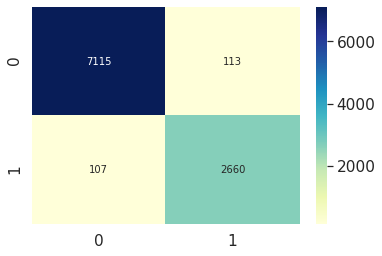

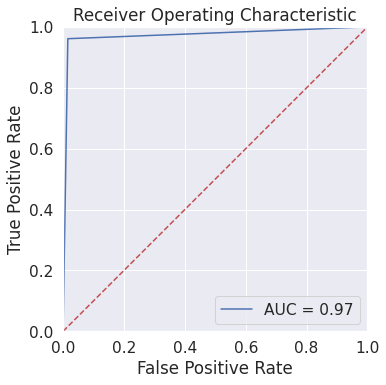

In [ ]:
y_pred = (tfidf_MLP.predict(tfidf_val) > 0.5).astype("int32")
display_results(y_pred, y_val)

### Train a Long Short Term Memory (LSTM) model on BERT Embeddings

In [ ]:
# https://stackoverflow.com/questions/62281260/how-to-use-cnn-and-lstm-for-nlp-with-bert-embeddings
from keras.layers import LeakyReLU
from keras.optimizers import Adam

reshaped_bert_train = bert_train.reshape(-1, 768, 1)
reshaped_bert_val = bert_val.reshape(-1, 768, 1)

bert_LSTM = Sequential()
bert_LSTM.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(768, 1)))
bert_LSTM.add(Bidirectional(LSTM(units=32)))
bert_LSTM.add(Dense(64, activation='relu'))
bert_LSTM.add(LeakyReLU(alpha=0.05))
bert_LSTM.add(Dense(32, activation='relu'))
bert_LSTM.add(LeakyReLU(alpha=0.05))
bert_LSTM.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=0.001)

bert_LSTM.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])
bert_LSTM.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_35 (Bidirectio (None, 768, 128)          33792     
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_55 (Dense)             (None, 64)                4160      
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 1)               

### Train the LSTM

In [69]:
batch_size = 32

unrelated, related = np.bincount(total_data['Relevance'])
total = unrelated + related

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

weight_for_0 = (1 / unrelated)*(total)/2.0 
weight_for_1 = (1 / related)*(total)/2.0

weight = {0: weight_for_0, 1: weight_for_1}

history = bert_LSTM.fit(reshaped_bert_train, y_train, batch_size=batch_size,
                        epochs=50, validation_data=(reshaped_bert_val, y_val), class_weight=weight)

Epoch 1/50
1250/1250 [==============================] - 153s 122ms/step - loss: 0.6887 - accuracy: 0.5636 - val_loss: 0.6792 - val_accuracy: 0.6251
Epoch 2/50
1250/1250 [==============================] - 153s 123ms/step - loss: 0.6844 - accuracy: 0.5905 - val_loss: 0.6854 - val_accuracy: 0.5533
Epoch 3/50
1250/1250 [==============================] - 154s 123ms/step - loss: 0.6827 - accuracy: 0.5777 - val_loss: 0.6833 - val_accuracy: 0.5697
Epoch 4/50
1250/1250 [==============================] - 155s 124ms/step - loss: 0.6799 - accuracy: 0.5859 - val_loss: 0.6805 - val_accuracy: 0.6068
Epoch 5/50
1250/1250 [==============================] - 156s 125ms/step - loss: 0.6771 - accuracy: 0.6193 - val_loss: 0.6715 - val_accuracy: 0.6290
Epoch 6/50
1250/1250 [==============================] - 156s 124ms/step - loss: 0.6735 - accuracy: 0.6187 - val_loss: 0.6690 - val_accuracy: 0.6499
Epoch 7/50
1250/1250 [==============================] - 156s 125ms/step - loss: 0.6702 - accuracy: 0.6379 - val_

### Display Results of LSTM on Related/Unrelated Classification

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      7228
           1       0.62      0.71      0.66      2767

    accuracy                           0.80      9995
   macro avg       0.75      0.77      0.76      9995
weighted avg       0.81      0.80      0.80      9995



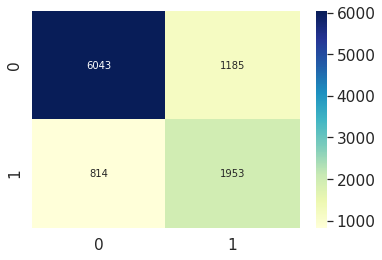

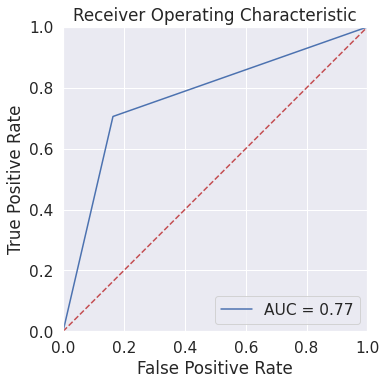

In [70]:
y_pred = (bert_LSTM.predict(reshaped_bert_val) > 0.5).astype("int32")
display_results(y_pred, y_test)